# Mask out irrelevant sections of Coen 2014 trials

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
import sys

from aux import get_seg
from disp import set_plot

FPS = 30.03
DT = 1/FPS

SMOOTH = int(round(1/DT))

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()
FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)

MASK_PFX = 'data/simple/masks/mask_tr'

In [2]:
df = pd.read_csv('data/simple/c_song_f_behav.csv')
df

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# load down sampled data and plot atop original
ntr = np.max(df['ID']) + 1
dfs_tr = [df[df['ID'] == itr] for itr in ISTRAIN]

In [4]:
SMOOTH = int(round(1/DT))
PAUSE_DUR = 30
IPAUSE_DUR = int(round(PAUSE_DUR/DT))

def make_mask(df_tr):
    
    t = df_tr['T']
    
    q = np.array(df_tr['Q'])
    
    ffv = df_tr['FFV']
    fls = df_tr['FLS']
    mtn = np.sqrt(ffv**2 + fls**2)
    
    mtn_smooth = smooth(mtn, SMOOTH)
   
    # make mask
    mask = np.ones(len(t), dtype=bool)
    
    # mask out all timepoints before first singing tp
    it_first_song = np.nonzero(~q)[0][0]
    mask[:it_first_song] = False
    
    # if any period longer than PAUSE_DUR w no singing, mask out all timepoints except first PAUSE_DUR seconds
    segs_q, bds_q = get_seg(q, min_gap=1)
    for it_start, it_end in bds_q:
        if (it_end - it_start) > IPAUSE_DUR:
            mask[it_start+IPAUSE_DUR:it_end] = False
            
    return mask

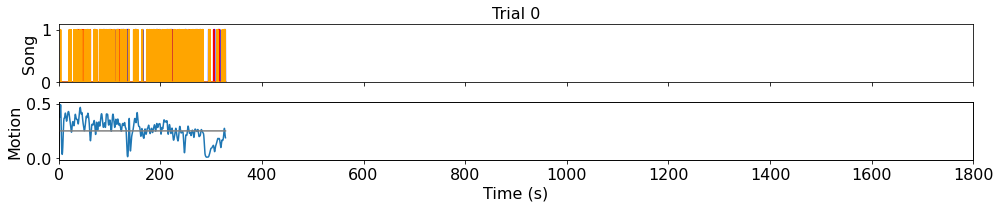

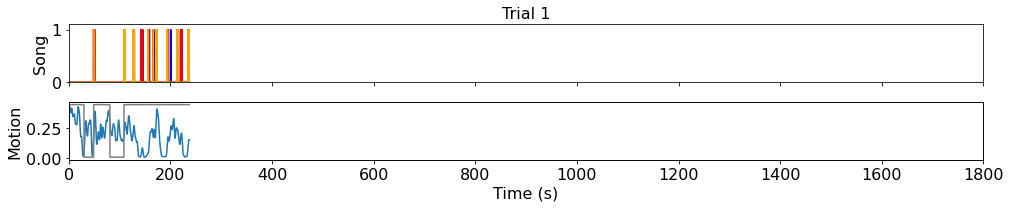

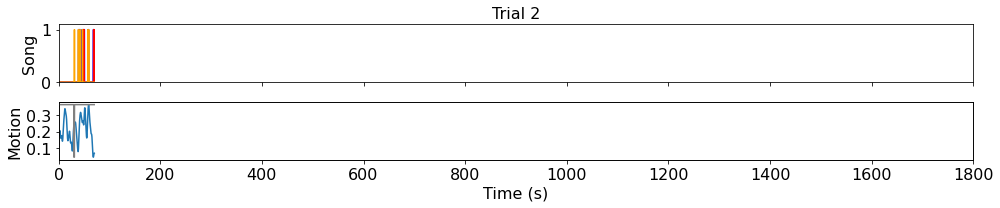

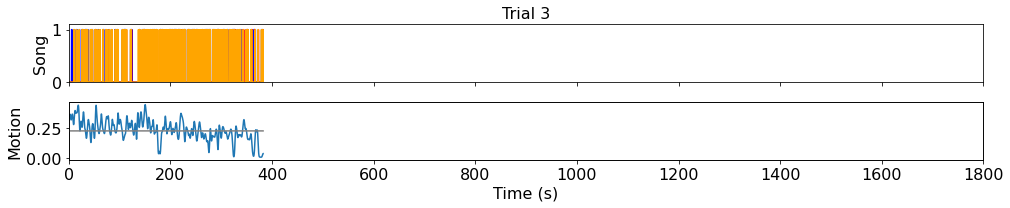

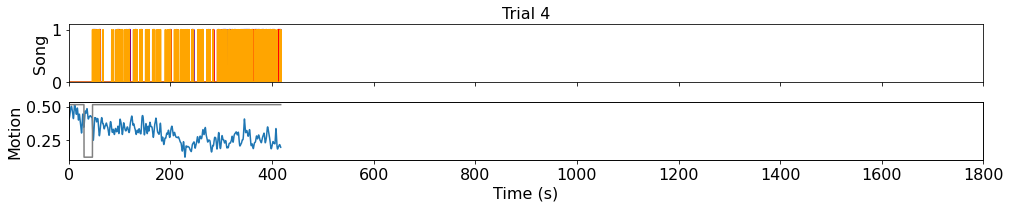

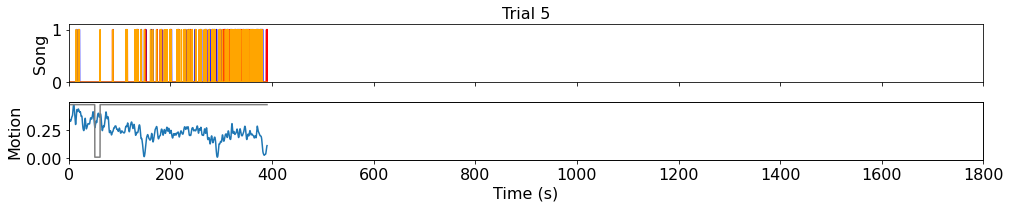

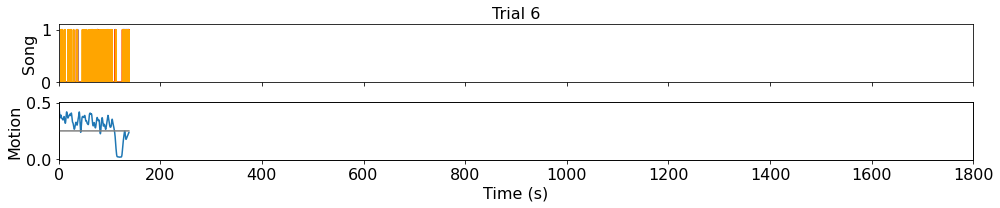

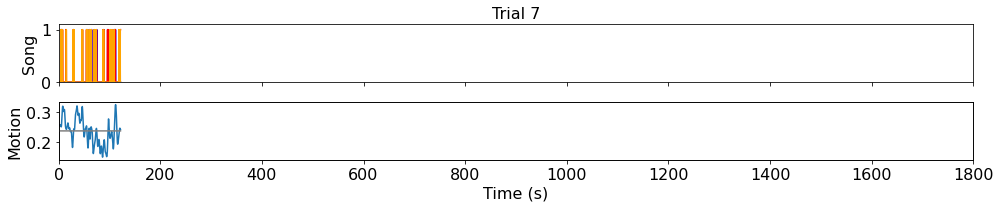

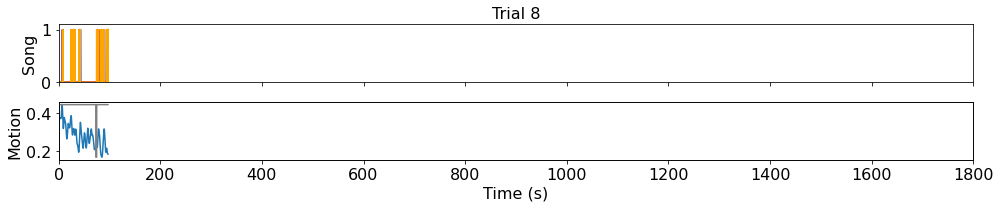

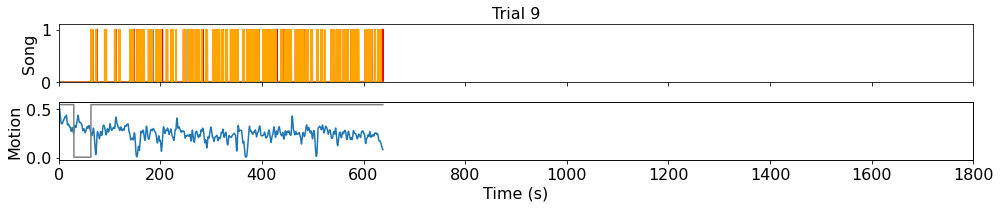

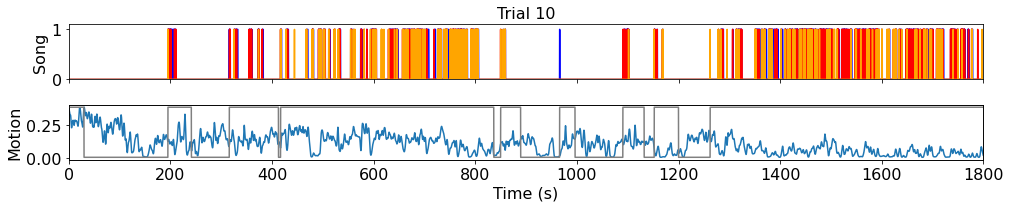

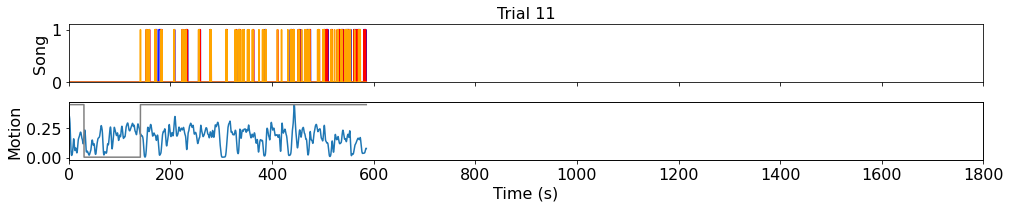

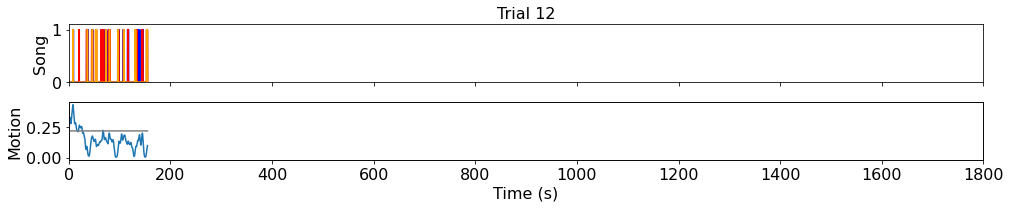

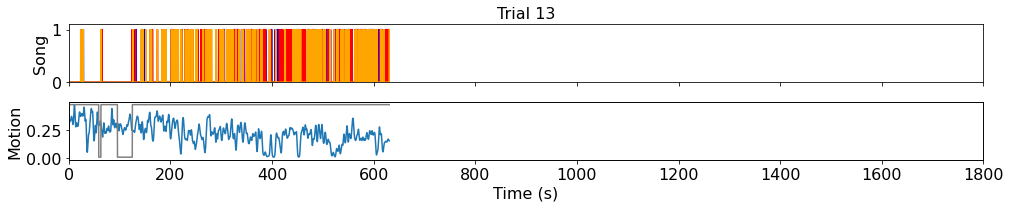

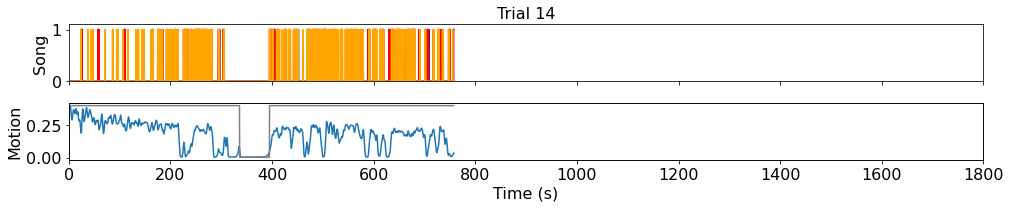

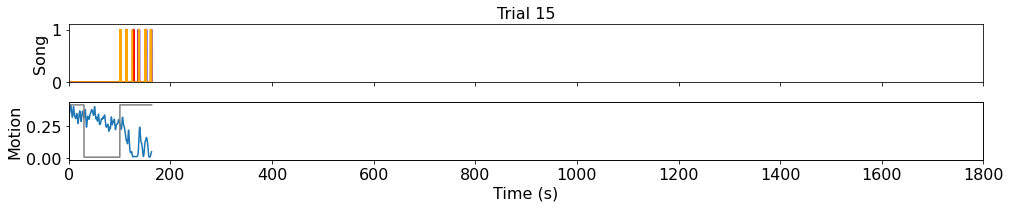

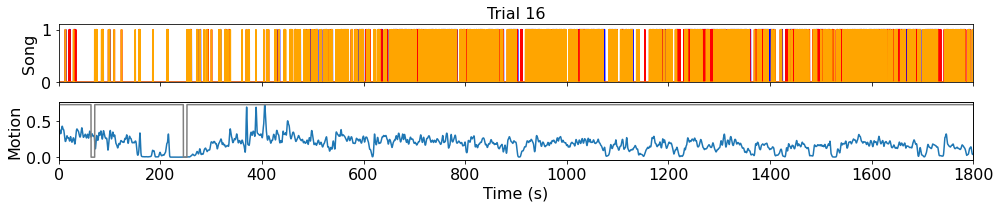

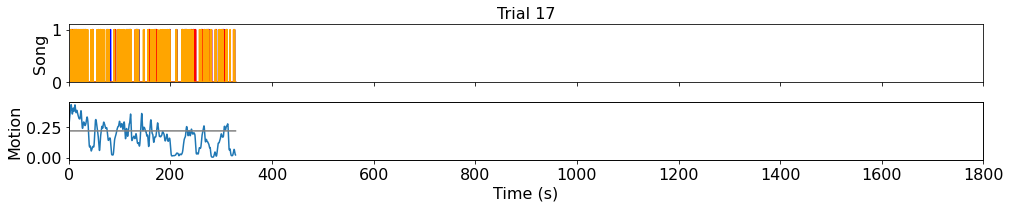

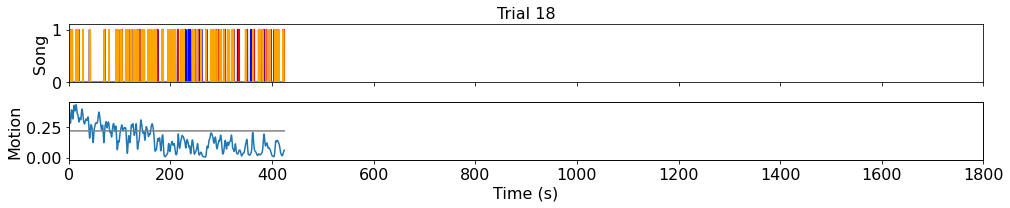

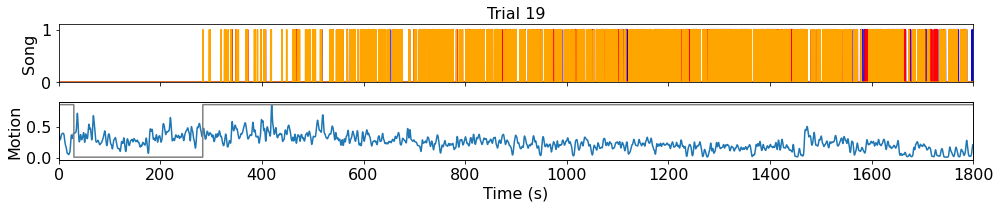

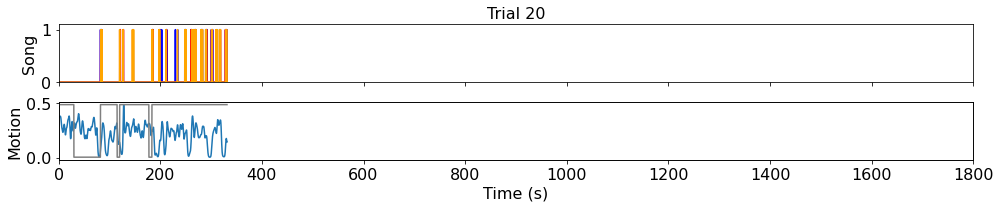

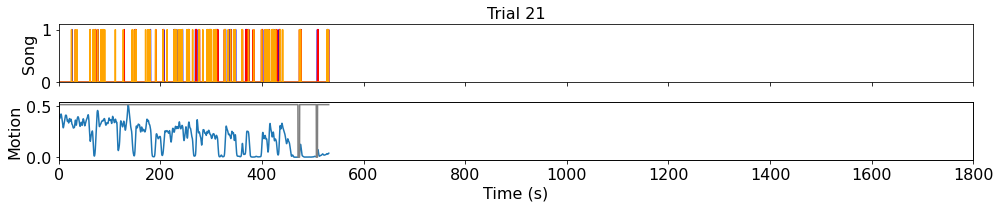

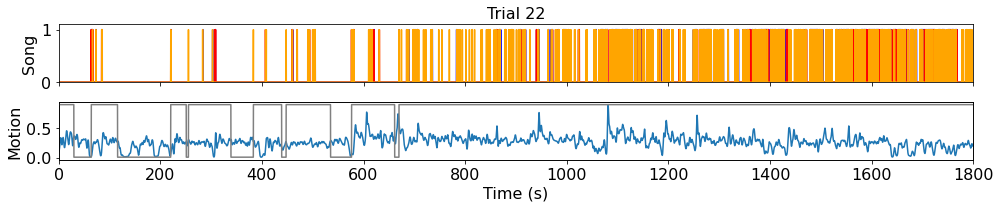

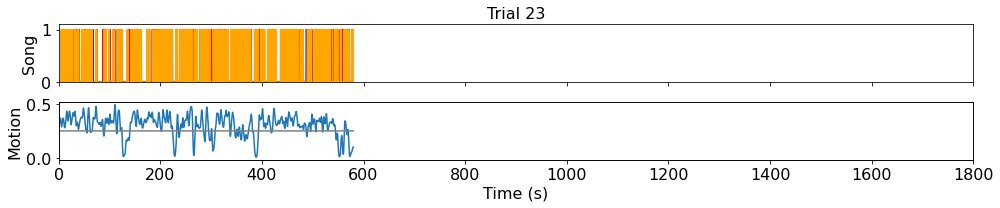

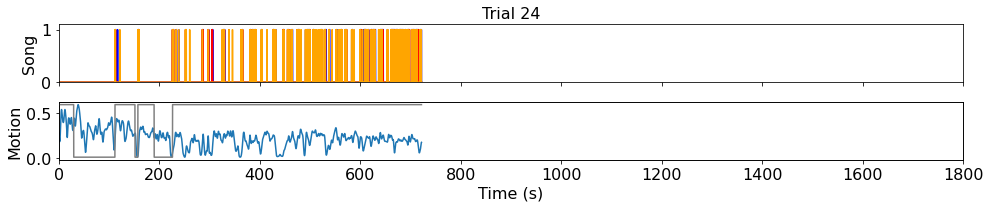

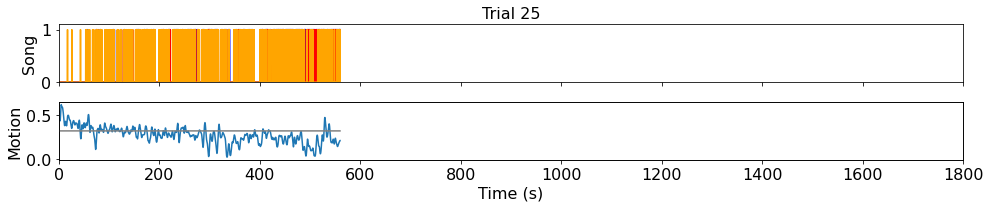

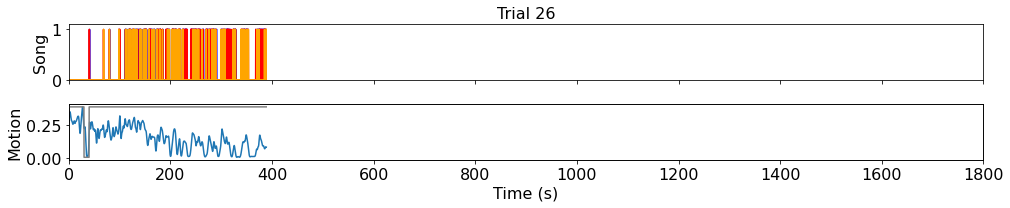

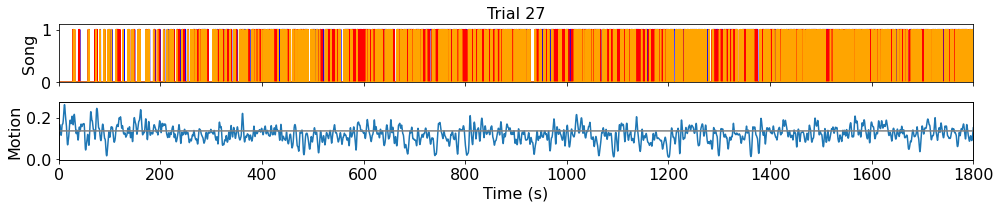

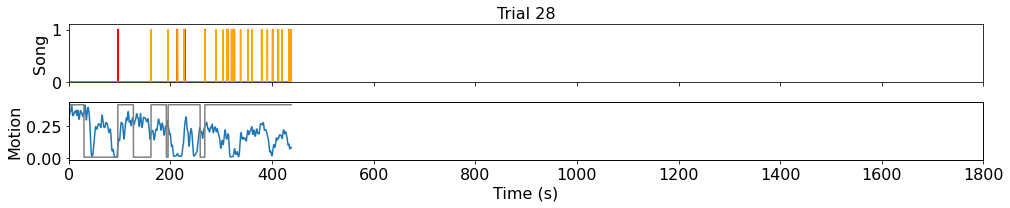

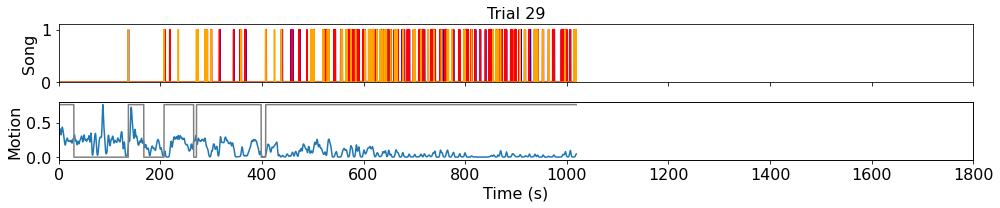

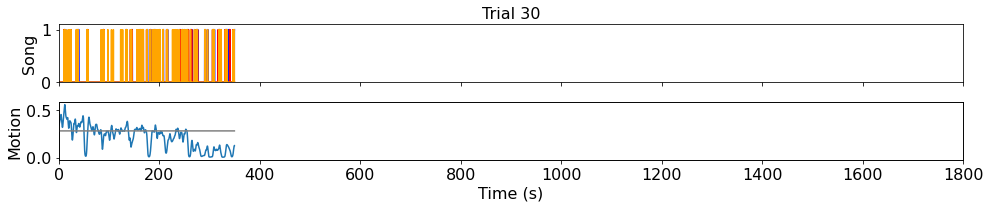

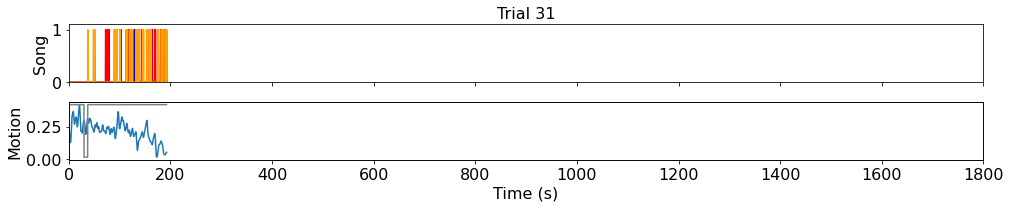

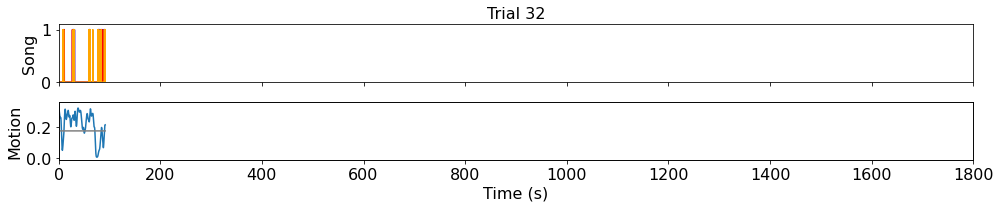

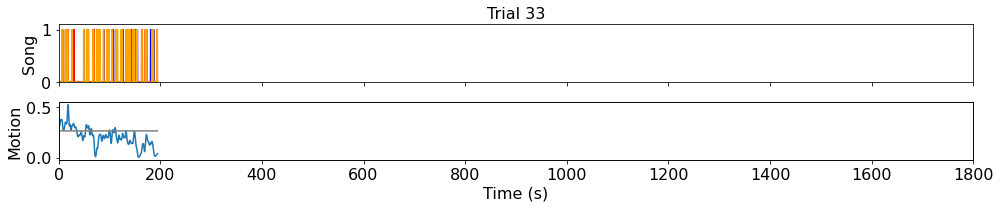

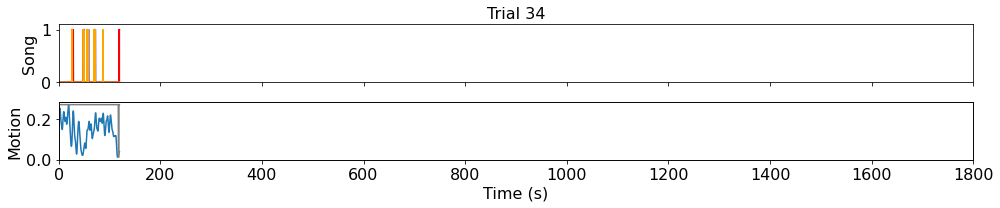

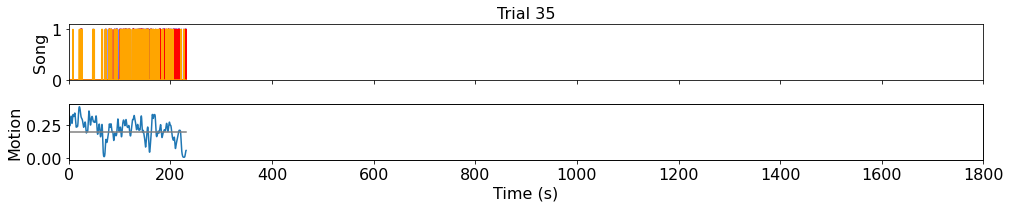

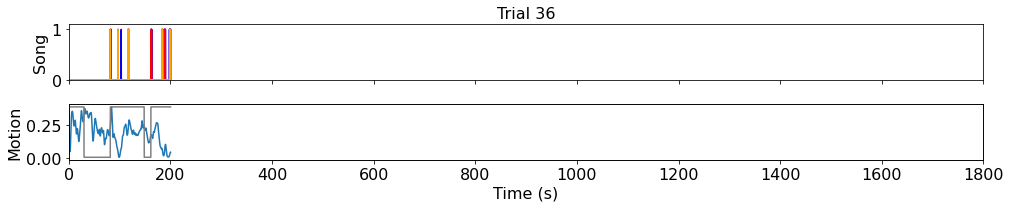

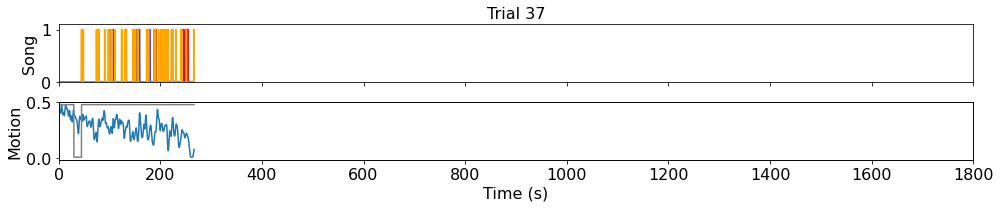

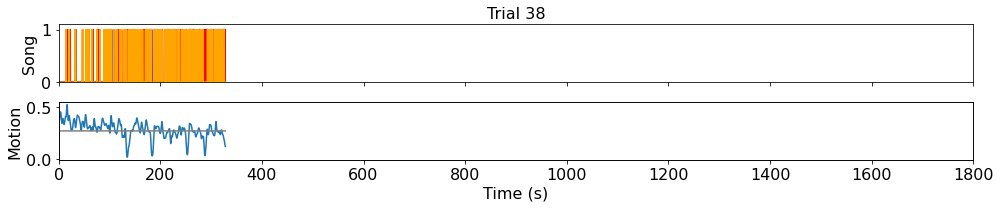

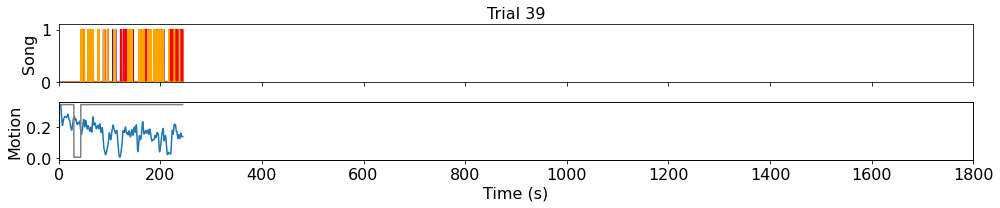

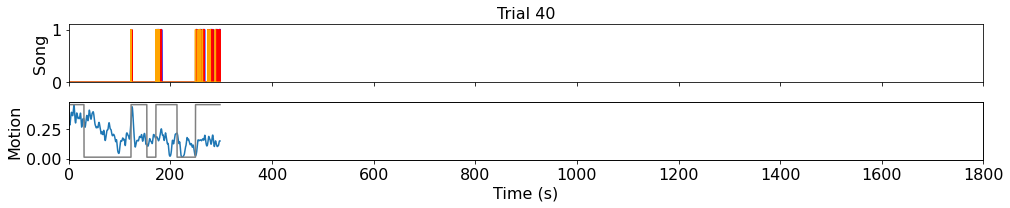

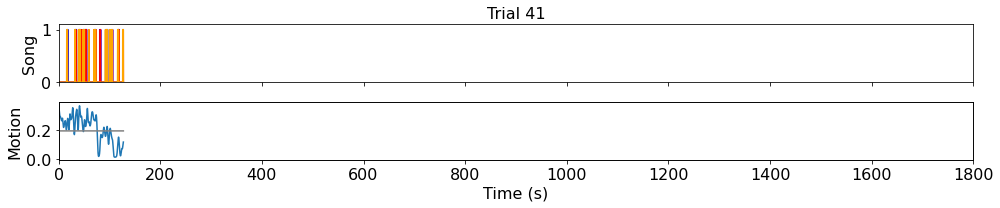

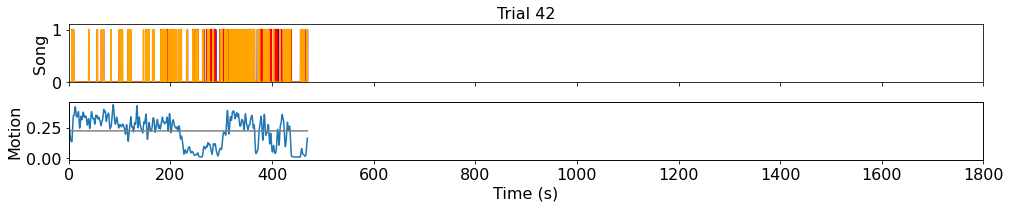

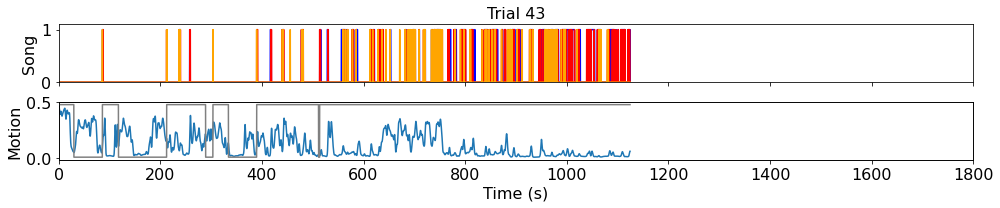

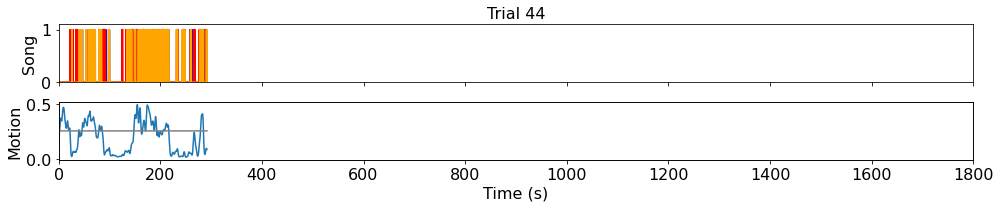

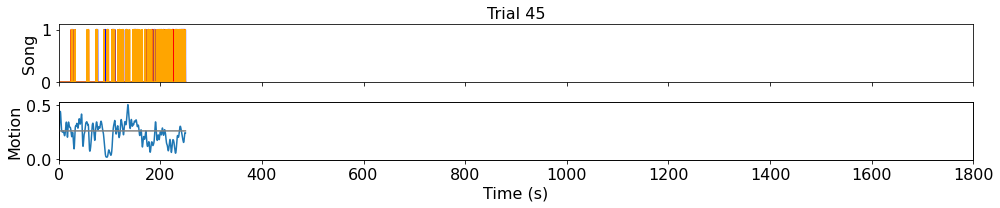

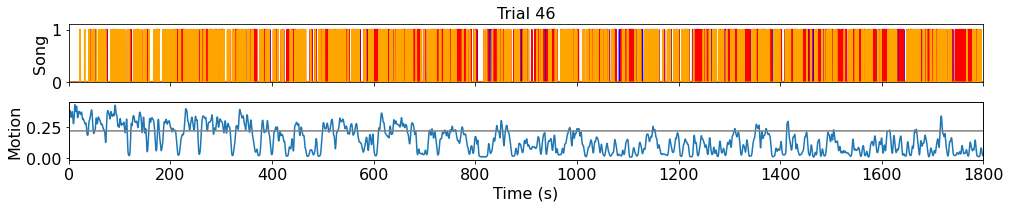

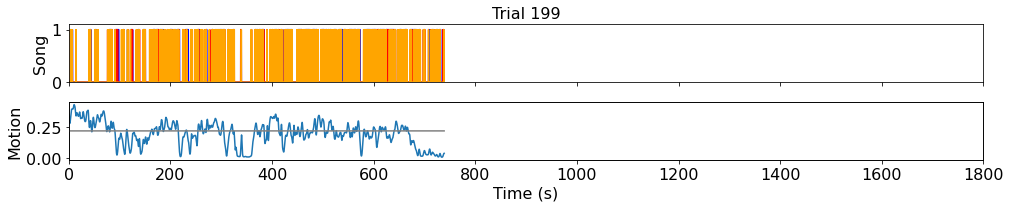

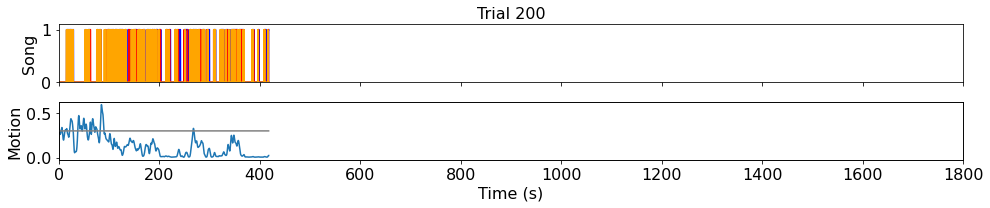

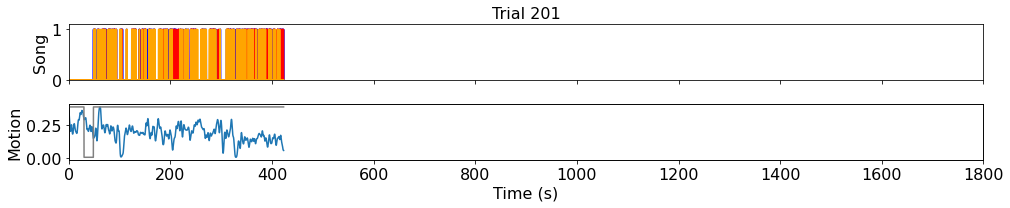

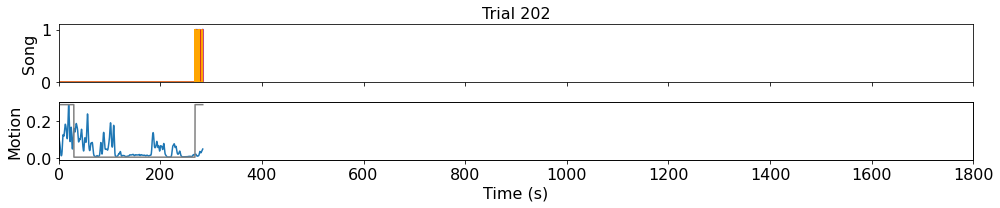

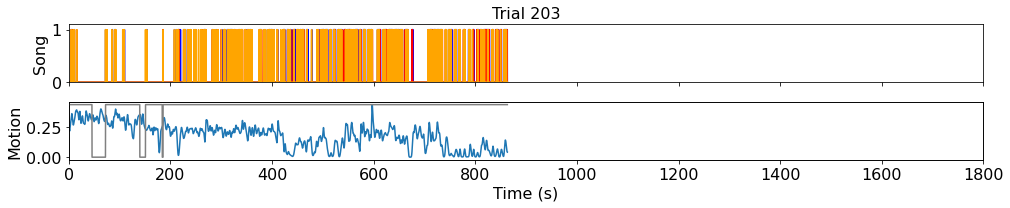

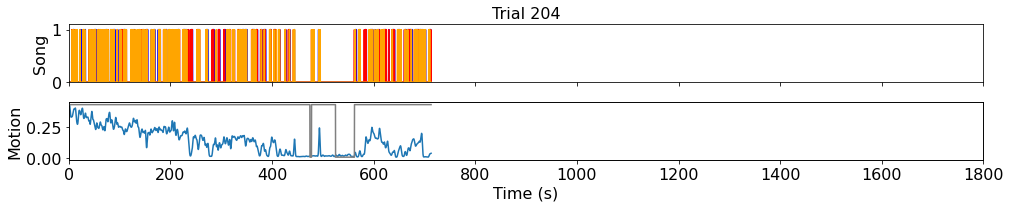

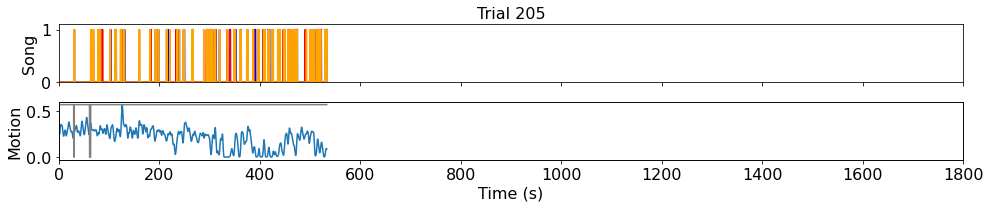

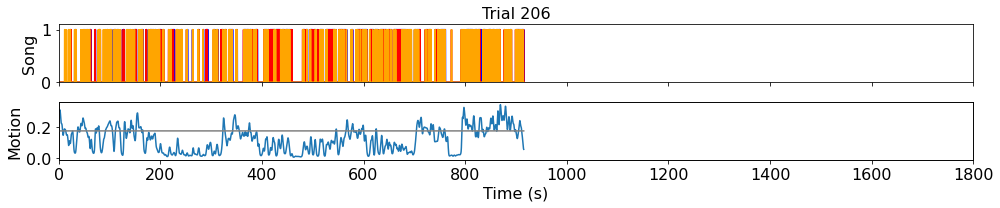

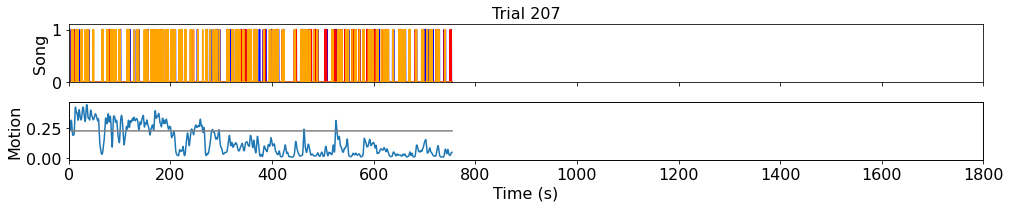

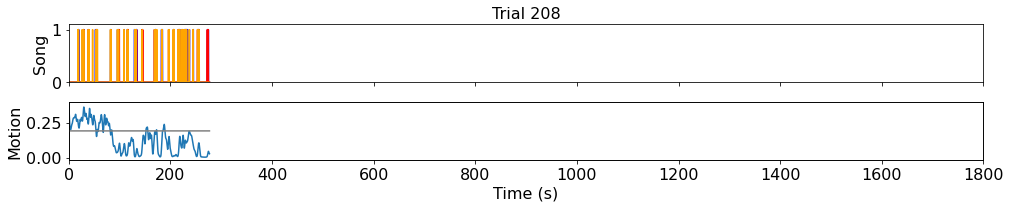

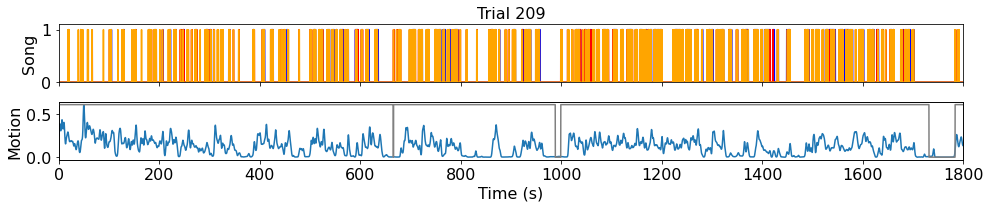

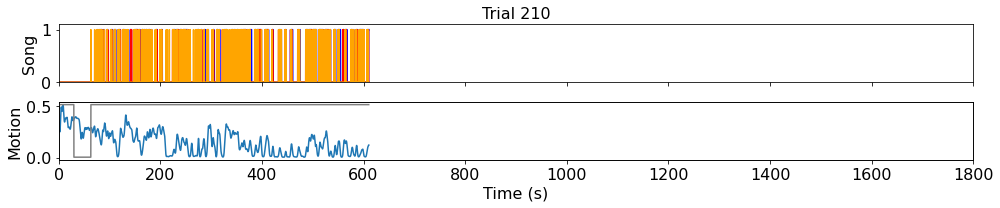

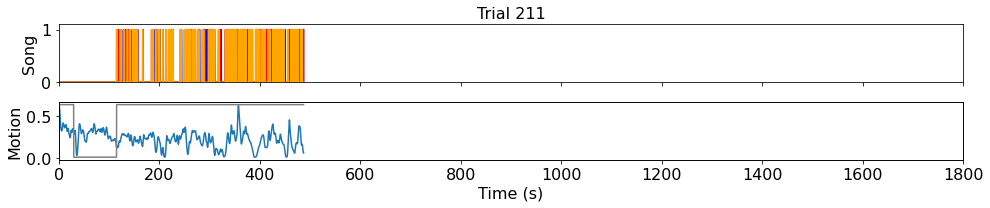

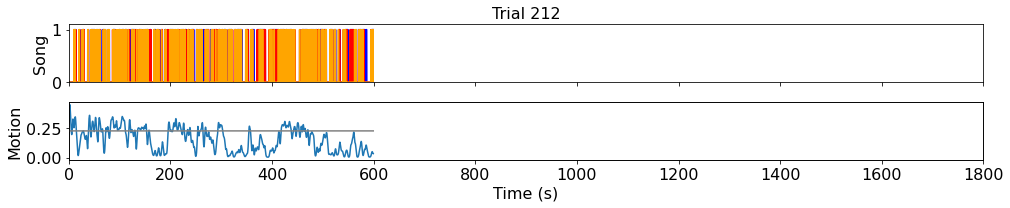

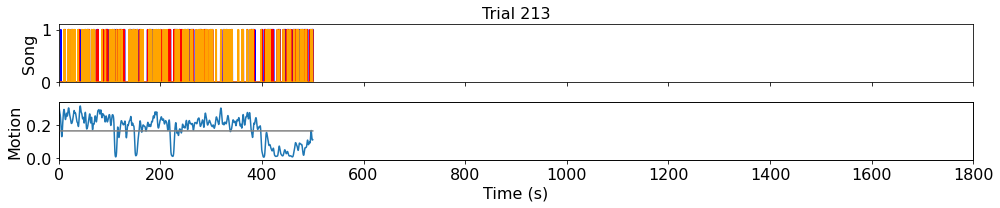

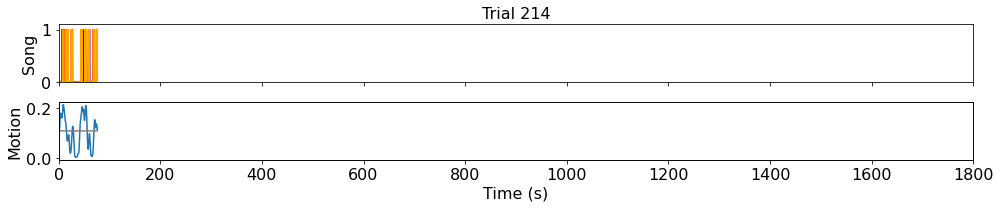

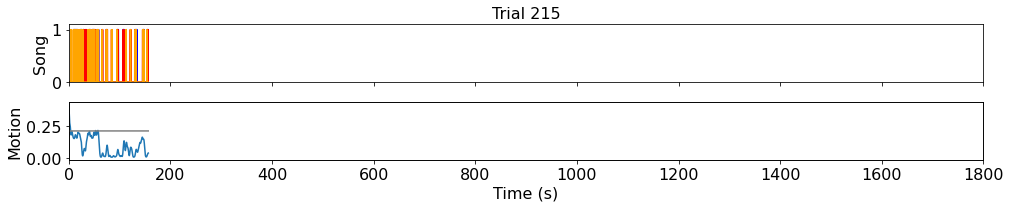

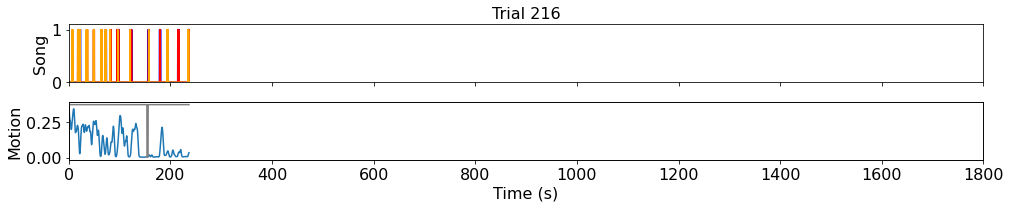

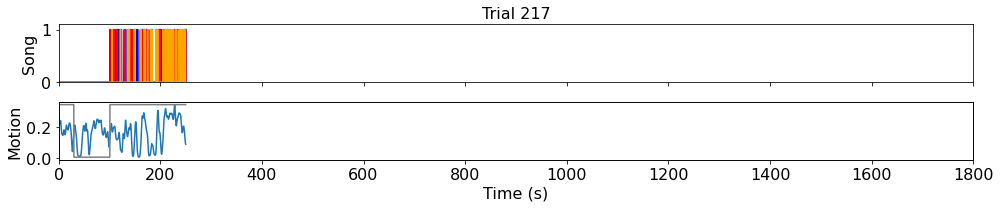

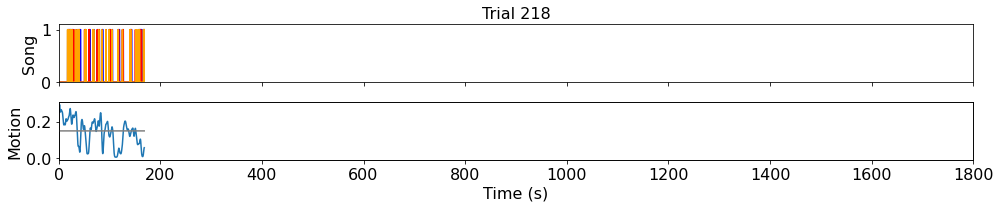

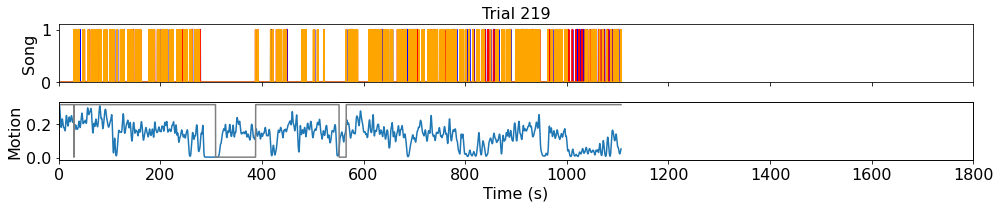

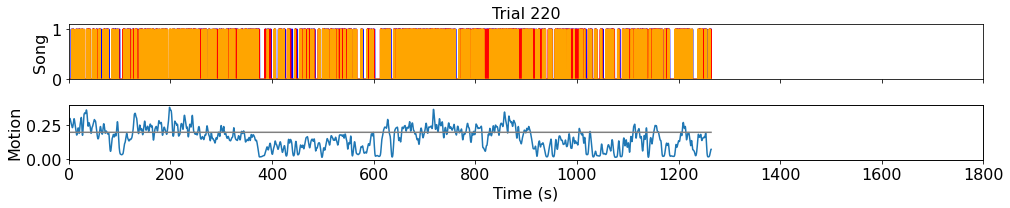

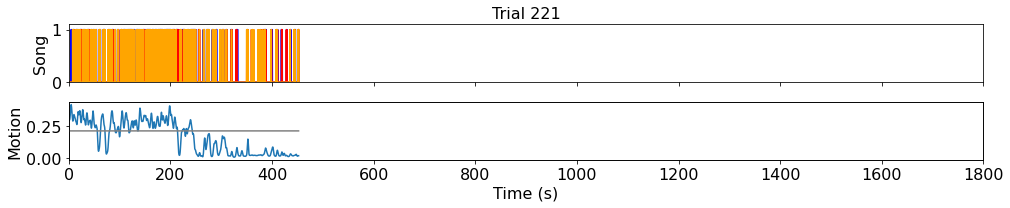

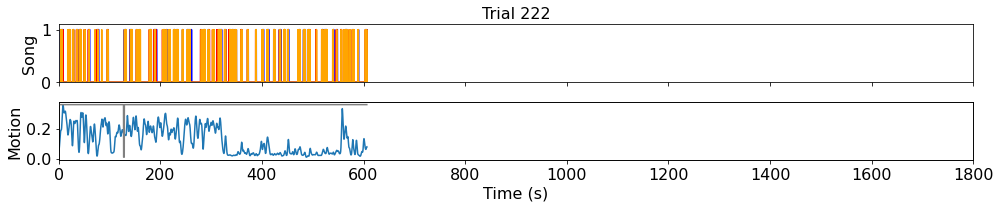

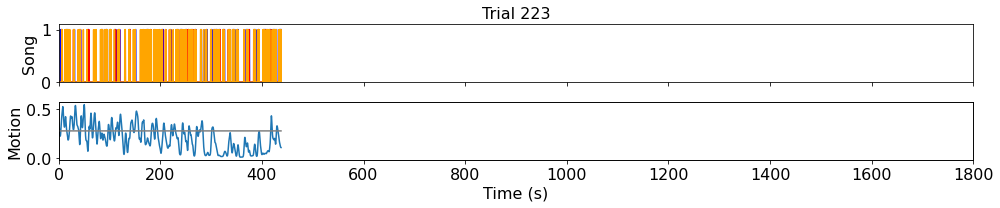

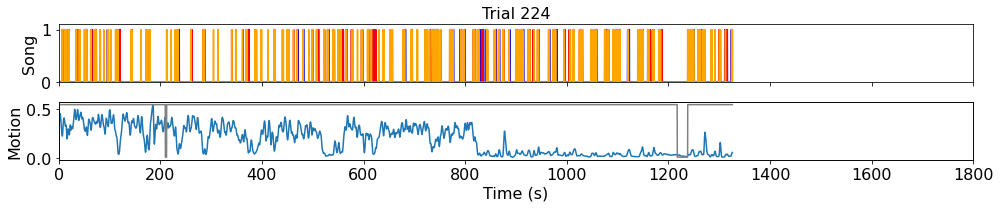

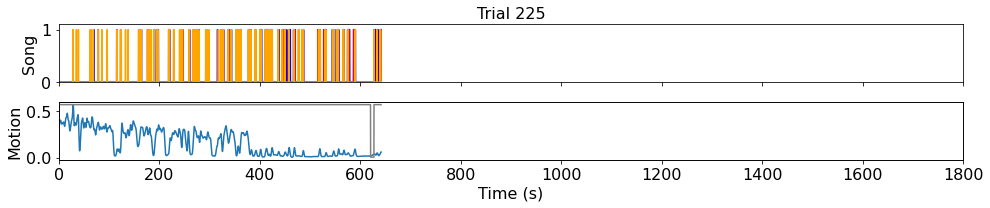

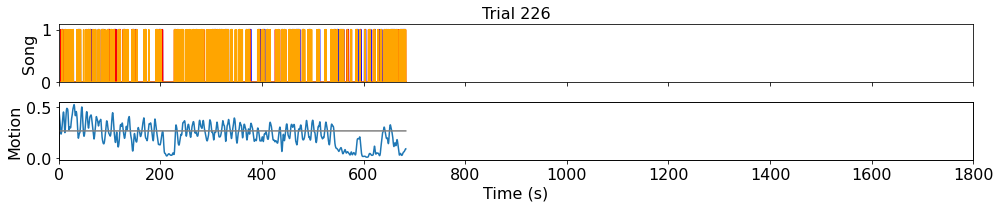

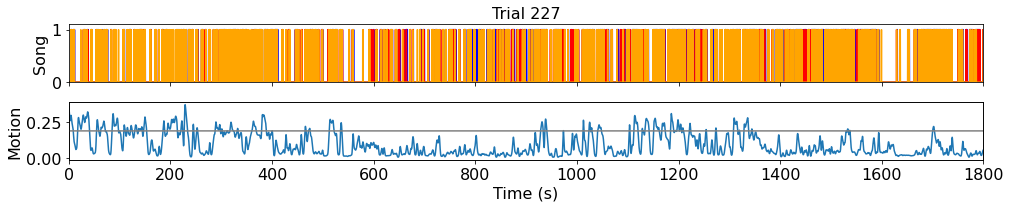

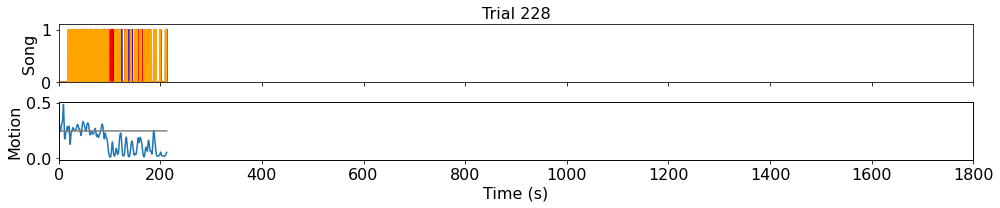

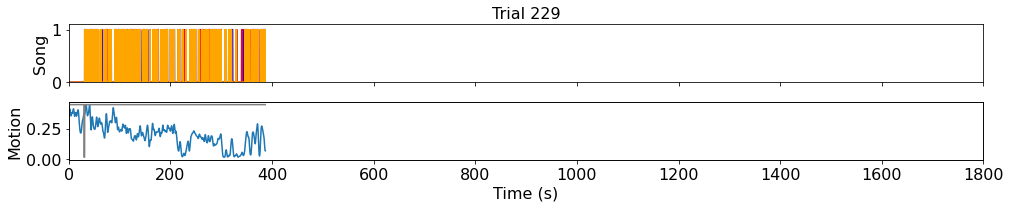

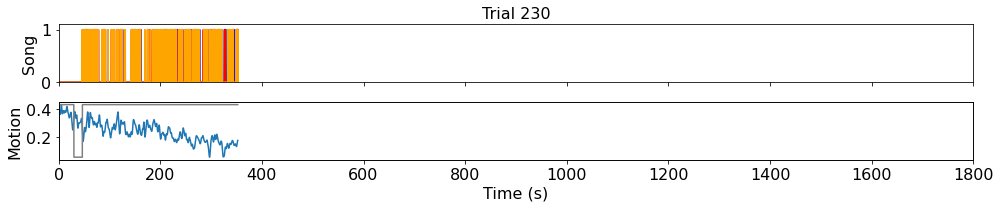

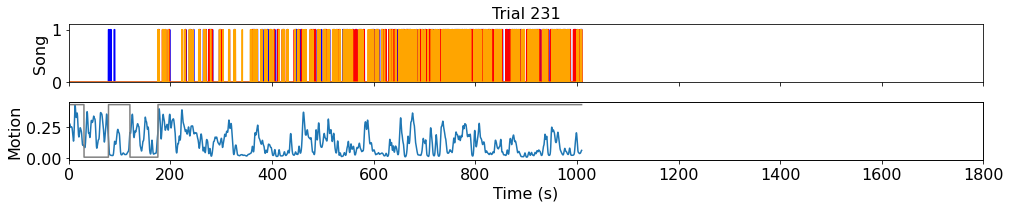

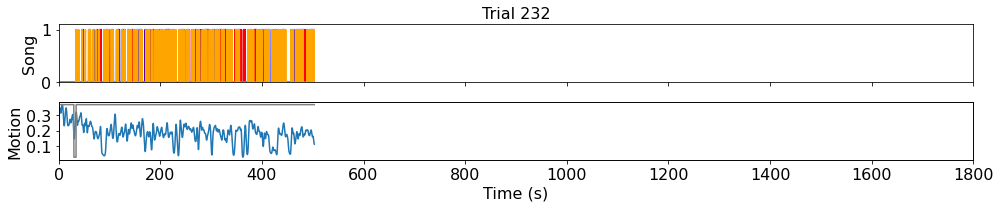

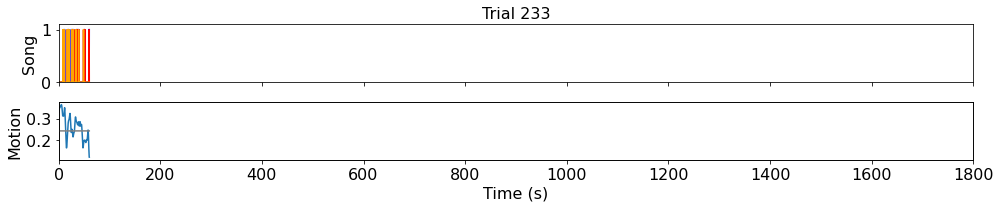

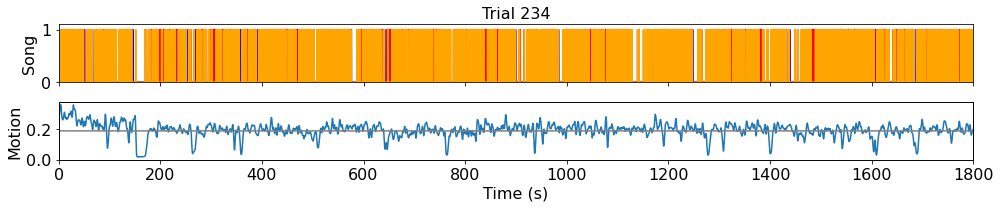

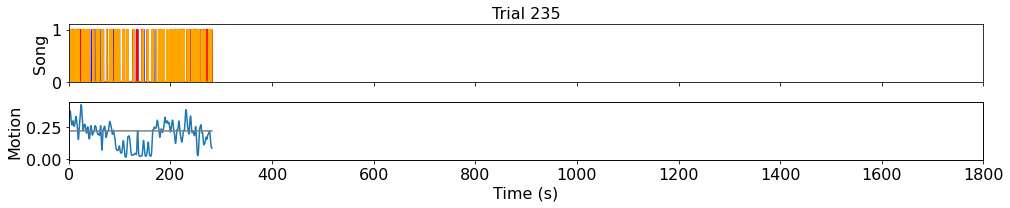

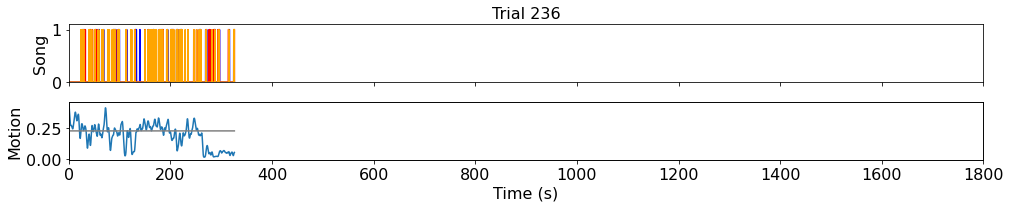

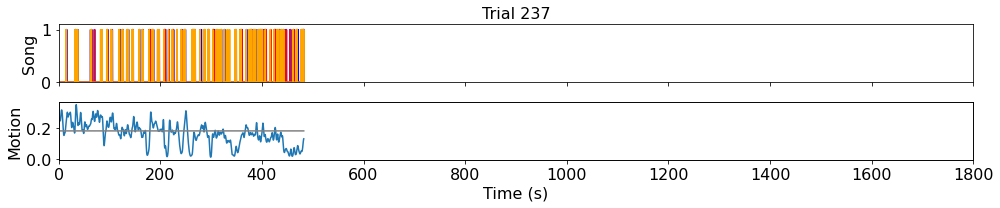

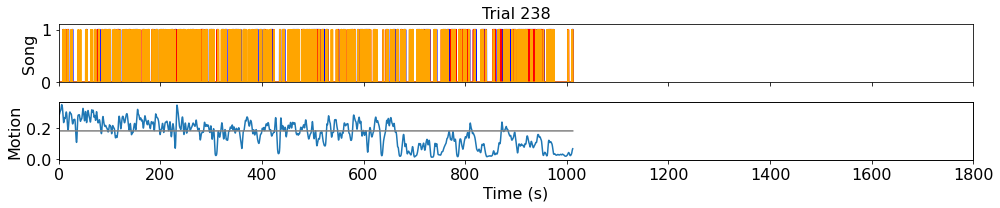

In [5]:
for ctr, df_tr in enumerate(dfs_tr):
    fig, axs = plt.subplots(2, 1, figsize=(14, 3), tight_layout=True, sharex=True)
    
    t = df_tr['T']
    q = df_tr['Q']
    s = df_tr['S']
    p = df_tr['P']
    f = df_tr['F']
    
    ffv = df_tr['FFV']
    fls = df_tr['FLS']
    
    mtn = np.sqrt(ffv**2 + fls**2)
    
    mask = make_mask(df_tr)
    
    itr = ISTRAIN[ctr]
    
    # save mask
    np.save(f'{MASK_PFX}_{itr}.npy', np.array([{'mask': mask}]))
    mask = None
    
    # load mask
    mask = np.load(f'{MASK_PFX}_{itr}.npy', allow_pickle=True)[0]['mask']
    
    # song
    axs[0].plot(t, s, c='b')
    axs[0].plot(t, p, c='r')
    axs[0].plot(t, f, c='orange')
    set_plot(axs[0], y_lim=(0, 1.1), y_label='Song', title=f'Trial {itr}', font_size=16)
    
    # motion
    axs[1].plot(t, smooth(mtn, SMOOTH))
    set_plot(axs[1], x_lim=(0, 1800), x_label='Time (s)', y_label='Motion', font_size=16)
    
    ax_twin = axs[1].twinx()
    ax_twin.plot(t, mask, c='gray')
    ax_twin.yaxis.set_visible(False)